# Cruxfinder


In [1]:
# Add enclosing directory to path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from langchain.chains.summarize import load_summarize_chain
from langchain.text_splitter import CharacterTextSplitter
from langchain import OpenAI, PromptTemplate, LLMChain
from langchain.chains.mapreduce import MapReduceChain
from langchain.embeddings import OpenAIEmbeddings
from langchain.docstore.document import Document
from langchain.chains import LLMChain
from langchain.llms import OpenAI
import matplotlib.pyplot as plt
from typing import List
import pandas as pd
import numpy as np
from langchain.vectorstores.utils import maximal_marginal_relevance
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import OnlineCountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from langchain.chains.question_answering import load_qa_chain
from bertopic.representation import LangChain
import pandas as pd
import nltk
import pickle
from path import Path

In [28]:
import re

# 1. Extract Long Form Arguments <a class="anchor" id="1"></a>

In [75]:
#data is from: https://www.dropbox.com/s/9o92tl86yy07tqi/alignment-scrape-clean-2022-11-12.zip?dl=0
import json

PATH = "/Users/saffron/projects/cip/cruxfinder/data/lesswrong.jsonl"
KEYS = ['source', 'comments', 'omega_karma', 'url', 'id', 'tags', 'authors', 'title', 'score', 'date_published', 'text', 'votes']

# Get data
data = []
for line in open(PATH, "r"):
    data.append(json.loads(line))

In [62]:
REPLACE_PAIRS = (
    ("\n", " "),
    ("\u200b", ""),
    ("*", ""),
    ("#", ""),
    ("  ", " "),
)

In [96]:
for post in data:
    for replace_pair in REPLACE_PAIRS:
        post['text'] = post['text'].replace(*replace_pair)

In [100]:
df = pd.DataFrame.from_dict(data)

In [184]:
def _token_count(chars: int) -> int:
    return round(chars / 6 * 1.4)  # Rough estimate, 6 chars per word, 1.4 tokens per word.

def _price_emb(chars: int) -> float:
    openai_emb_price_per_token = 0.0004 / 1000
    return round(openai_emb_price_per_token * _token_count(chars), 3)

Let's just get AI timelines arguments for now!

In [201]:
timelines = df[df['tags'].apply(lambda x: 'AI Timelines' in str(x))]
print(len(timelines))

85


In [202]:
timelines['tokens'] = timelines['text'].apply(lambda x: _token_count(len(str(x))))

In [253]:
timelines = timelines[timelines['tokens'] < 3500]

(array([ 7., 13.,  6.,  3.,  4.,  3.,  1.,  2.,  2.,  7.]),
 array([ 147. ,  455.3,  763.6, 1071.9, 1380.2, 1688.5, 1996.8, 2305.1,
        2613.4, 2921.7, 3230. ]),
 <BarContainer object of 10 artists>)

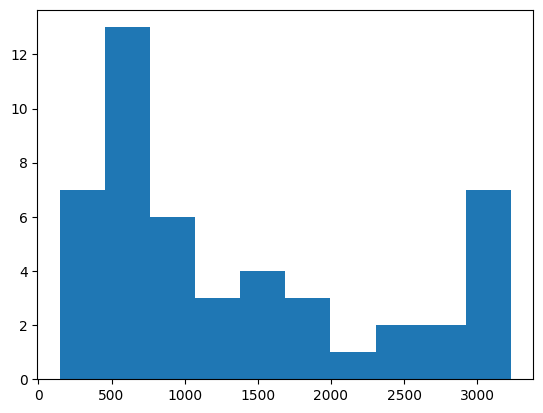

In [255]:
plt.hist(timelines["tokens"])

In [256]:
len(timelines)

48

# Prompt for bullet-point summaries

best thing is probably to summarize each post into a couple of bullets each. Also makes it easier to plug in the shorter open ended question data into this process.

In [327]:
# summarize each into main 5-10 points. then compare them with each other and identify cruxes.
main_points_template = """
You are an AI assistant trained to summarize blog posts into their main reasons/points in 5-10 bullet points. Feel free to ignore irrelevant context.

This is the blog post:
{post}

This is your summary:"""

In [328]:
main_points_prompt = PromptTemplate(
    template=main_points_template,
    input_variables=["post"],
)

main_points_prompt.format(post="test")

'\nYou are an AI assistant trained to summarize blog posts into their main reasons/points in 5-10 bullet points. Feel free to ignore irrelevant context.\n\nThis is the blog post:\ntest\n\nThis is your summary:'

In [329]:
main_points_chain = LLMChain(
    llm=OpenAI(temperature=0.1, presence_penalty=0.3, verbose=True),
    prompt=main_points_prompt,
    verbose=True,
)

In [330]:
timelines = timelines.reset_index(drop=True)

In [ ]:
for i in range(len(timelines)):
    timelines.loc[i, 'bullets'] = main_points_chain.predict(post=timelines['text'].iloc[i])

# Prompt for cruxes

In [332]:
# First, simple crux template
crux_template1 = """
You are an AI assistant trained to find the crux or cruxes between two arguments (i.e. the statement(s) on which the argument(s) turn, which essentially determine whether the two parties agree or disagree.

This is the first argument:
{arg1}

This is the second argument:
{arg2}

This is the crux/cruxes:"""

crux_prompt1 = PromptTemplate(
    template=crux_template1,
    input_variables=["arg1", "arg2"],
)

crux_chain1 = LLMChain(
    llm=OpenAI(temperature=0.1, presence_penalty=0.3, verbose=True),
    prompt=crux_prompt1,
    verbose=True,
)

# Second one that I think is better
crux_template = """
You are an AI assistant trained to find the crux or cruxes between two arguments (i.e. the identifies the core belief or assumption, for each party, that underlies their position on the issue.) You identify the crux or cruxes for each party, and whether they are the same, so that the parties can examine them and look for resolutions.

You not only suggest the crux or cruxes, you also suggest how to move forward after identifying the cruxes.

This is the first argument:
{arg1}

This is the second argument:
{arg2}

This is the crux/cruxes of each argument, and any suggestions on how to move forward in the argument:"""

crux_prompt = PromptTemplate(
    template=crux_template,
    input_variables=["arg1", "arg2"],
)

crux_chain = LLMChain(
    llm=OpenAI(temperature=0.1, presence_penalty=0.3, verbose=True),
    prompt=crux_prompt,
    verbose=True,
)

found 2 arguments that might be interesting to compare:

In [322]:
print(crux_chain.predict(arg1=timelines['bullets'][10], arg2=timelines['bullets'][36]))



> Entering new LLMChain chain...
Prompt after formatting:

You are an AI assistant trained to find the crux or cruxes between two arguments (i.e. the identifies the core belief or assumption, for each party, that underlies their position on the issue.) You identify the crux or cruxes for each party, and whether they are the same, so that the parties can examine them and look for resolutions.

You not only suggest the crux or cruxes, you also suggest how to move forward after identifying the cruxes.

This is the first argument:

- This post is about timelines for AGI, not takeoff speeds.
- Timelines are usually not strategically relevant to alignment research decisions.
- It would take ~18 months to take the current best idea, implement it, and deploy it.
- Long-term research should focus on building better foundational understanding, running experiments, and searching for better ideas.
- Strategic decisions outside of object-level research may depend on timelines of ~5 years or less.

next: try on claude / conjecture????